In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import sem
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.cm import get_cmap
import colorsys


In [2]:
## set up file list & subject list ##
# several versions of the task are run. To pull subjects of interest, get information from this file

# Enter desired subject ID
subjectid = 'DA30'
pinfo = pd.read_csv('/Users/sdiaw/Library/CloudStorage/Box-Box/iEEG_MAZE_project/DATA/BEHAVIOR/patient cohort/participants.csv')
dlist = ["/Users/sdiaw/Library/CloudStorage/Box-Box/iEEG_MAZE_project/DATA/BEHAVIOR/patient cohort/all patient data/{}".format(subj) for subj in list(pinfo['subject id'])]

filepath = f'/Users/sdiaw/Documents/MazeStudy/behavioral/behavior analysis/analysis/{subjectid}.csv'

subject_df = pd.read_csv(filepath)
print(dlist)

['/Users/sdiaw/Library/CloudStorage/Box-Box/iEEG_MAZE_project/DATA/BEHAVIOR/patient cohort/all patient data/DA17', '/Users/sdiaw/Library/CloudStorage/Box-Box/iEEG_MAZE_project/DATA/BEHAVIOR/patient cohort/all patient data/DA18', '/Users/sdiaw/Library/CloudStorage/Box-Box/iEEG_MAZE_project/DATA/BEHAVIOR/patient cohort/all patient data/DA19_1', '/Users/sdiaw/Library/CloudStorage/Box-Box/iEEG_MAZE_project/DATA/BEHAVIOR/patient cohort/all patient data/DA19_2', '/Users/sdiaw/Library/CloudStorage/Box-Box/iEEG_MAZE_project/DATA/BEHAVIOR/patient cohort/all patient data/DA22', '/Users/sdiaw/Library/CloudStorage/Box-Box/iEEG_MAZE_project/DATA/BEHAVIOR/patient cohort/all patient data/DA23', '/Users/sdiaw/Library/CloudStorage/Box-Box/iEEG_MAZE_project/DATA/BEHAVIOR/patient cohort/all patient data/IR103', '/Users/sdiaw/Library/CloudStorage/Box-Box/iEEG_MAZE_project/DATA/BEHAVIOR/patient cohort/all patient data/DA30']


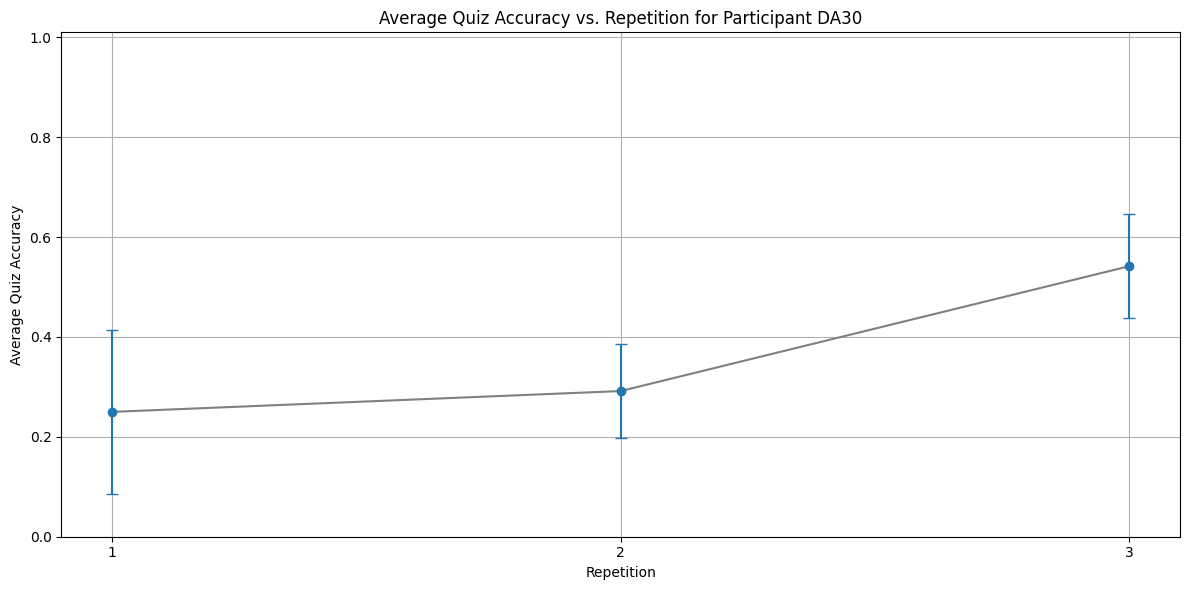

In [3]:
participant_data = subject_df

# Filter data for rows where the task column is equal to 'contextual_quiz_click' and remove NaN values
quiz_data = participant_data[participant_data['task'] == 'contextual_quiz_click'].dropna(subset=['quiz_acc'])

# Calculate average quiz accuracy for each block
avg_block_quiz_accuracy = quiz_data.groupby('block')['quiz_acc'].mean().reset_index()

# Exclude blocks with average quiz accuracy below 15%
blocks_to_exclude = avg_block_quiz_accuracy[avg_block_quiz_accuracy['quiz_acc'] < 0.15]['block']
quiz_data = quiz_data[~quiz_data['block'].isin(blocks_to_exclude)]

# Calculate average quiz accuracy for each repetition
avg_quiz_accuracy = quiz_data.groupby('repetition')['quiz_acc'].mean().reset_index()
sem_quiz_accuracy = quiz_data.groupby('repetition')['quiz_acc'].sem().reset_index()


# Set up a figure for the plot
plt.figure(figsize=(12, 6))
plt.title("Average Quiz Accuracy vs. Repetition for Participant %s"%subjectid)
plt.xlabel("Repetition")
plt.ylabel("Average Quiz Accuracy")
plt.ylim(0, 1.01)  # Set y-axis limits to 0 and 1

# Plot average quiz accuracy vs. repetition with error bars
plt.errorbar(avg_quiz_accuracy['repetition'] + 1, avg_quiz_accuracy['quiz_acc'], yerr=sem_quiz_accuracy['quiz_acc'],
             fmt='o', capsize=4, label='Average Quiz Accuracy')

# Add a line connecting the data points
plt.plot(avg_quiz_accuracy['repetition'] + 1, avg_quiz_accuracy['quiz_acc'], marker='', linestyle='-', color='gray')

# Customize x-axis ticks
plt.xticks([1, 2, 3], ['1', '2', '3'])

plt.grid(True)
plt.tight_layout()

# Save or show the plot
plt.savefig("%s_average_quiz_accuracy_vs_repetition.png"%subjectid)
plt.show()  # Uncomment if you want to display the plot interactively


# Plotting Average Navigation Reaction Time Across Blocks

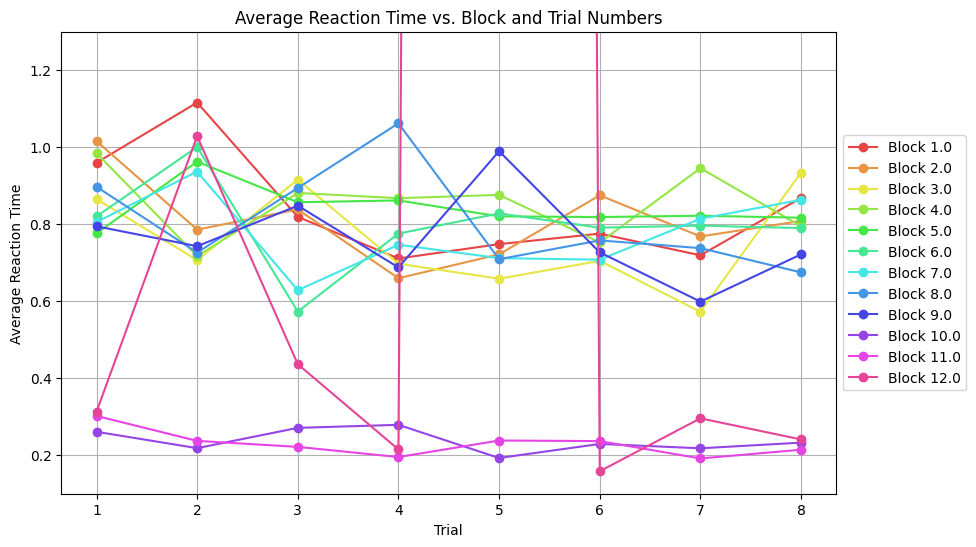

In [4]:
# Selecting relevant columns and dropping rows with NaN values
filtered_df = subject_df[subject_df['task'] == 'nav']

filtered_df = filtered_df[['block', 'trial', 'rt']].dropna()

# Calculating average reaction time for each block and trial combination
averages = filtered_df.groupby(['block', 'trial'])['rt'].mean().reset_index()

# Getting a list of unique blocks
unique_blocks = averages['block'].unique()

# Generate 12 distinct colors using colorsys
num_colors = len(unique_blocks)
colors = [colorsys.hsv_to_rgb(i/num_colors, 0.7, 0.9) for i in range(num_colors)]

# Plotting
plt.figure(figsize=(10, 6))

# Iterate through each block
for i, block in enumerate(unique_blocks):
    block_data = averages[averages['block'] == block]
    color = colors[i]
    plt.plot(block_data['trial'], block_data['rt'], marker='o', color=color, label=f'Block {block}')

plt.xlabel('Trial')
plt.ylabel('Average Reaction Time')
plt.title('Average Reaction Time vs. Block and Trial Numbers')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

# Set y-axis limits (adjust the values as needed)
plt.ylim(0.1, 1.3)  # Example y-axis limits

plt.show()

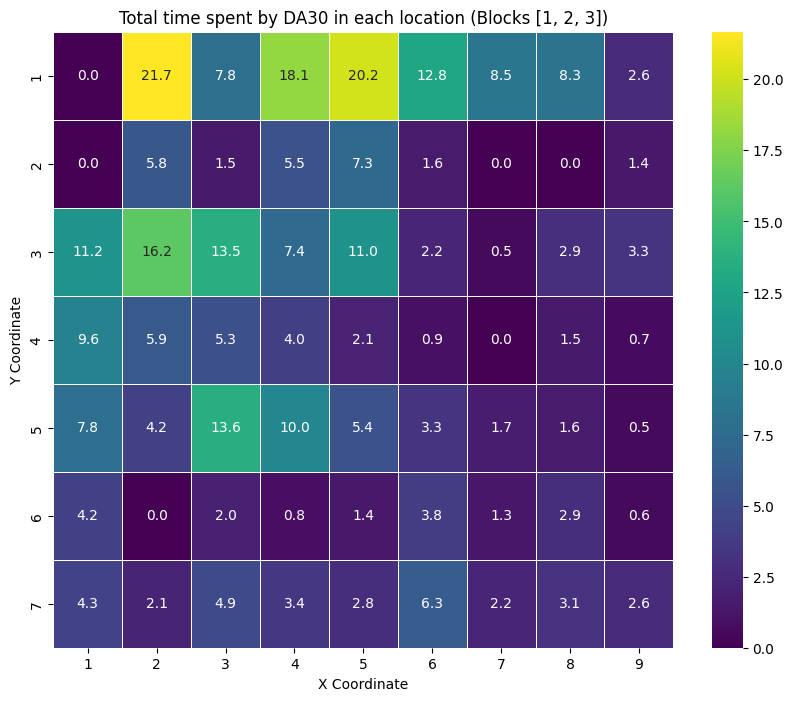

In [5]:
# Select blocks to include
blocks = [1,2,3]


participant_files = []

for subjdir in dlist:
    # extract subject-specific information to be added in the group summary
    subjstr = subjdir.split('/')[-1]
    filepath = f'/Users/sdiaw/Documents/MazeStudy/behavioral/behavior analysis/analysis/{subjstr}.csv'
    participant_files.append(filepath)

# Create an empty list to hold the DataFrames
data_frames = []

# Loop through participant files and load data into DataFrames
for file_path in participant_files:
    participant_id = file_path.split("/")[-1].split(".")[0]  # Extract ID from the file path
    participant_data = pd.read_csv(file_path)
    participant_data['participant'] = participant_id
    data_frames.append(participant_data)

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(data_frames, ignore_index=True)

filtered_df = all_data[(all_data['participant'] == subjectid) & (~all_data['coordinate'].isna())].copy()
filtered_df = filtered_df[filtered_df['block'].isin(blocks)]
filtered_df['coordinate'] = filtered_df['coordinate'].astype(str).str.strip('()')
filtered_df[['x', 'y']] = filtered_df['coordinate'].str.split(',', expand=True).astype(float).round().astype(int)

# Exclude the (1,1) coordinate
filtered_df = filtered_df[(filtered_df['x'] != 1) | (filtered_df['y'] != 1)]

# Group the DataFrame by 'x' and 'y' and sum the 'rt' values for each coordinate
heatmap_data = filtered_df.groupby(['y', 'x'])['rt'].sum().unstack(fill_value=0)

# Create the heatmap using Seaborn with the x-coordinates on the x-axis and y-coordinates on the y-axis
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".1f", linewidths=0.5)
plt.title(f'Total time spent by {subjectid} in each location (Blocks {blocks})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()
